In [28]:
import  IPython.display as ipd
import sys
sys.path.append('..')
sys.path.append('../../../Vocoders')
from ParallelWaveGAN.Networks.build_model import build_model as mbmelgan_build_model
from ParallelWaveGAN.Utils.losses.pqmf import PQMF

sys.path.append('../../../MultiSpeaker/GlowTTS/')
from AutoEncoder.Networks.build_model import build_model as ae_build_model

import yaml 
import torch
with open('../Configs/config1.yml') as f:
    config = yaml.safe_load(f)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
melgan_config_path = '../../../Vocoders/ParallelWaveGAN/logs/20200814/melgan_config_exp2.yml'
with open(melgan_config_path) as f:
    melgan_config = yaml.safe_load(f)
mbmelgan = mbmelgan_build_model(
    generator_type=melgan_config['generator_type'],
    discriminator_type=melgan_config['discriminator_type'],
    model_params={
        'generator': melgan_config['generator_params'],
        'discriminator': melgan_config['discriminator_params'],
    })[0]
    
pqmf = PQMF(4, cutoff_ratio=0.142)
mbmelgan_params = torch.load('../../../Vocoders/ParallelWaveGAN/logs/20200716/epoch_995.pth', map_location='cpu')
mbmelgan.load_state_dict(mbmelgan_params['model']['generator'])


<All keys matched successfully>

In [30]:
ae, _ = ae_build_model('unet', use_pitch=False)
params = torch.load('../../../MultiSpeaker/GlowTTS/AutoEncoder/logs/20200710_multi/epoch_00200_generator.pth', map_location='cpu')
_ = ae.load_state_dict(params)
_ = ae.eval()

In [31]:
from Utils.build_dataloader import build_dataloader
val_path = '../Data/val_list_3_ft.txt'
with open(val_path, 'r') as f:
    val_list = f.readlines()
    
val_loader = build_dataloader(val_list, batch_size=1, dataset_config={'data_augmentation': False}, validation=True)

DEBUG:Utils.build_dataloader:sr: 24000
n_fft: 2048
hop_length: 300
win_length: 1200


In [32]:

from Networks.build_model import build_model
config_path = '../logs/20200828/config3_ft.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

model = build_model(config['model_params'])
params = torch.load('../logs/20200828/epoch_00020.pth', map_location='cpu')["model"]
model.load_state_dict(params)

initialize TextEncoder
initialize AudioEncoder
initialize AudioSeq2seq
initialize MergeNet
initialize SpeakerClassifier
initialize SpeakerEncoder
initialize PostNet


<All keys matched successfully>

In [33]:
path = val_loader.dataset.data_list[0][0]
wav, mel, _ = torch.load(path)
mel2 = to_mel(wav)


In [34]:
cmel = (torch.log(1e-5 + mel) + 4) / 4

In [37]:

for idx, data in enumerate(val_loader):
    if idx == 700:
        data2 = data
        break
    if idx == 200:
        data1 = data
        break
        

mel_ref = data2[3]
text, text_len, mel_input, mel,  mel_len, spk_id = data1

In [38]:
import torchaudio
import librosa
to_mel = torchaudio.transforms.MelSpectrogram(
     n_fft=2048,
    win_length=1200,
    hop_length=300,
    n_mels=80,
    )

In [39]:
ipd.Audio(wav, rate=24000)


In [42]:
import soundfile as sf
ood_path = 'sample2.wav'
wav, sr = sf.read(ood_path)
wav = librosa.resample(wav, sr, 24000)
wav = wav / np.abs(wav).max() * 0.999
ood_mel = to_mel(torch.from_numpy(wav).float())

ood_mel = (torch.log(1e-5 + ood_mel) + 4) / 4

ood_mel = ood_mel[:, :ood_mel.size(1)-ood_mel.size(1)%2]
ood_mel_len = torch.LongTensor([ood_mel.shape[1]])
ood_mel = ood_mel.unsqueeze(0)


In [43]:

with torch.no_grad():
    pred_data = model.inference(
        #text_input=text,
        #text_lengths=text_len,
        mel_source=ood_mel, 
        mel_source_lengths=ood_mel_len, 
        mel_reference=mel_ref, )
    
    

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [45]:
post_out = pred_data['post_output']
stop = pred_data['predict_stop']

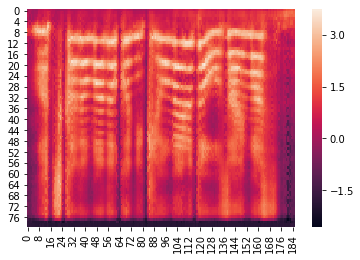

In [46]:
sns.heatmap(post_out[0])

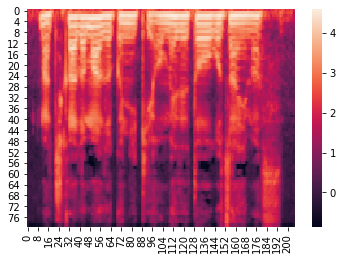

In [47]:
sns.heatmap(ood_mel[0] + 1)

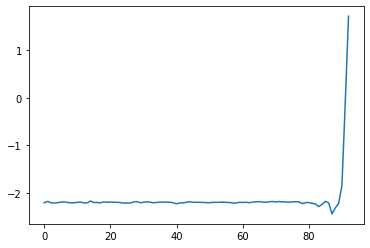

In [48]:
plt.plot(stop.squeeze().numpy())

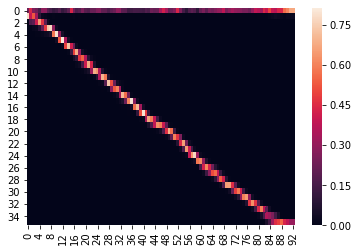

In [49]:
attn = pred_data['alignment']
sns.heatmap(attn[0].numpy().T)

In [50]:
with torch.no_grad():
    #_post_out = ae(post_out.unsqueeze(1)).squeeze(1)
    ref = mbmelgan(mel_ref[:1])
    ref = pqmf.synthesis(ref)
    ref = ref.squeeze()
    orig = mbmelgan(ood_mel) #mel_input)
    orig = pqmf.synthesis(orig)
    orig = orig.squeeze()
    #y = mbmelgan(_post_out)
    y = mbmelgan(post_out)
    y = pqmf.synthesis(y)
    y = y.squeeze()

In [51]:
ipd.Audio(y.numpy(), rate=24000)

In [52]:
ipd.Audio(orig.numpy(), rate=24000)

In [53]:
ipd.Audio(ref.numpy(), rate=24000)

In [43]:
pred_data['predict_speaker_id']

tensor([91])

In [141]:
with torch.no_grad():           
    text, text_lengths, mel_input, mel_target, mel_target_lengths, speaker_ids = data
    output = model(text, text_lengths, mel_input,  mel_target_lengths,
                       auto_encoding=False)

In [142]:
output['audio_seq2seq_logit'].softmax(dim=2)[0].argmax(dim=1)

tensor([ 4, 33, 10,  9, 11, 29, 14, 22, 29, 22, 18, 26, 18, 27, 27, 32, 29, 23,
        23, 23, 21, 10, 10, 23, 16, 29, 16, 21, 21,  4, 26, 29, 26, 18, 20, 14,
        22, 18, 22, 23, 22, 29,  4, 10,  4, 18,  9, 20, 28, 26, 22, 29, 27, 27,
        18, 18, 14, 18, 23, 23, 29,  4,  4,  2, 32, 25, 24, 32, 32, 28, 18, 28,
        28, 23, 14, 18, 22, 14, 22, 10, 26, 32, 13, 13, 27, 13])

In [143]:
output['audio_seq2seq_logit'].softmax(dim=2)[0].max(dim=1)[0]

tensor([0.8815, 0.6136, 0.4900, 0.9297, 0.5809, 0.2915, 0.2133, 0.3633, 0.7505,
        0.1413, 0.3033, 0.4633, 0.3775, 0.3323, 0.4637, 0.8041, 0.2004, 0.6697,
        0.5184, 0.6796, 0.2427, 0.4733, 0.4960, 0.2417, 0.1213, 0.1798, 0.1940,
        0.4237, 0.1534, 0.5950, 0.3604, 0.2944, 0.3089, 0.5134, 0.3791, 0.5585,
        0.5832, 0.9419, 0.6342, 0.3350, 0.1676, 0.1903, 0.2977, 0.1774, 0.3273,
        0.5071, 0.3291, 0.1996, 0.2303, 0.2279, 0.2402, 0.1357, 0.7341, 0.3562,
        0.3796, 0.2263, 0.3757, 0.9357, 0.3834, 0.5102, 0.5329, 0.3094, 0.2436,
        0.1813, 0.4246, 0.3479, 0.2600, 0.7310, 0.1633, 0.1989, 0.4954, 0.1726,
        0.4682, 0.7745, 0.3373, 0.9234, 0.3889, 0.5145, 0.2052, 0.3295, 0.1599,
        0.5205, 0.3412, 0.4499, 0.4484, 0.2980])

In [144]:
ce = torch.nn.CrossEntropyLoss(reduce=False)


/home/ryo/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [145]:
ce(output['audio_seq2seq_logit'][:, :-1].reshape(-1, 41), text.reshape(-1))

tensor([0.1261, 0.4884, 1.6918, 0.0729, 0.5432, 3.1634, 1.5450, 2.3847, 4.3355,
        2.1385, 1.9955, 0.7694, 0.9742, 3.3324, 0.7686, 0.2181, 2.7655, 5.0535,
        3.0511, 3.6555, 1.8130, 1.4553, 2.3954, 1.4200, 4.1637, 2.4959, 3.8732,
        5.9414, 1.9170, 0.5192, 3.4945, 2.5119, 4.0660, 1.0004, 3.4845, 2.4099,
        7.6272, 4.7927, 7.2686, 1.0935, 3.3909, 2.6155, 6.5492, 3.5622, 4.6718,
        0.6791, 6.4913, 5.2552, 8.6830, 7.1953, 4.9129, 1.9975, 2.9509, 5.3126,
        5.1470, 5.2308, 2.6084, 0.0665, 2.4704, 2.1925, 4.8361, 4.1298, 1.4122,
        4.8009, 3.9595, 1.0557, 1.3471, 5.8789, 3.1493, 4.8331, 0.7023, 1.7917,
        0.7588, 0.2556, 2.5927, 0.0796, 2.6919, 0.6646, 5.3897, 3.9331, 3.6884,
        0.6530, 1.1756, 2.3198, 4.4875])

In [146]:
p = list(zip(output['audio_seq2seq_logit'].softmax(dim=2)[0].argmax(dim=1), text[0], ce(output['audio_seq2seq_logit'][:, :-1].reshape(-1, 41), text.reshape(-1))))

In [147]:
output['audio_seq2seq_logit'].softmax(dim=2).max(dim=2)

torch.return_types.max(
values=tensor([[0.8815, 0.6136, 0.4900, 0.9297, 0.5809, 0.2915, 0.2133, 0.3633, 0.7505,
         0.1413, 0.3033, 0.4633, 0.3775, 0.3323, 0.4637, 0.8041, 0.2004, 0.6697,
         0.5184, 0.6796, 0.2427, 0.4733, 0.4960, 0.2417, 0.1213, 0.1798, 0.1940,
         0.4237, 0.1534, 0.5950, 0.3604, 0.2944, 0.3089, 0.5134, 0.3791, 0.5585,
         0.5832, 0.9419, 0.6342, 0.3350, 0.1676, 0.1903, 0.2977, 0.1774, 0.3273,
         0.5071, 0.3291, 0.1996, 0.2303, 0.2279, 0.2402, 0.1357, 0.7341, 0.3562,
         0.3796, 0.2263, 0.3757, 0.9357, 0.3834, 0.5102, 0.5329, 0.3094, 0.2436,
         0.1813, 0.4246, 0.3479, 0.2600, 0.7310, 0.1633, 0.1989, 0.4954, 0.1726,
         0.4682, 0.7745, 0.3373, 0.9234, 0.3889, 0.5145, 0.2052, 0.3295, 0.1599,
         0.5205, 0.3412, 0.4499, 0.4484, 0.2980]]),
indices=tensor([[ 4, 33, 10,  9, 11, 29, 14, 22, 29, 22, 18, 26, 18, 27, 27, 32, 29, 23,
         23, 23, 21, 10, 10, 23, 16, 29, 16, 21, 21,  4, 26, 29, 26, 18, 20, 14,
         22, 18, 2

In [148]:
np.mean([u[0]==u[1] for u in p])

0.2823529411764706

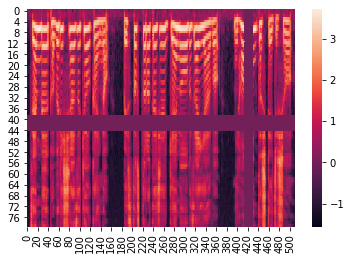

In [149]:
import seaborn as sns
%matplotlib inline
sns.heatmap(mel_input[0].numpy())

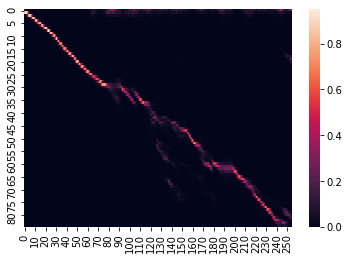

In [150]:
sns.heatmap(output['alignments'][0].numpy().T)